This notebook takes CLIP-voxels (brain voxels that have already been mapped to CLIP space via contrastive learning) and then uses a diffusion model to better align these CLIP-voxels to CLIP-image space (i.e., this is how DallE-2 uses a diffusion prior to go from CLIP-text space to CLIP-image space, as the spaces are still disjointed after contrastive learning).

# Import packages & functions

In [3]:
import os
import sys
import math
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import pandas as pd
from collections import OrderedDict

from utils import * 
from models import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

seed_everything(seed=0)

In [2]:
# setup multi-gpu Data Distributed Processing (ddp) if available
# if not using ddp, using_ddp should be False and local_rank=0
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import ddp_config
using_ddp,local_rank = ddp_config.ddp_test()
if device=='cuda':
    torch.cuda.set_device(local_rank)

NOT using distributed parallel processing!


In [3]:
# if full_training is True, use large batches and the entire training dataset 
full_training = True
print('full_training:',full_training)

full_training: True


## Which pretrained model are you using for voxel alignment to embedding space? 

In [4]:
img_augmentation = True # do image augmentation?
soft_clip = True # use loss_nce + loss_soft?

model_name = f'clip_image_vitL_aug{img_augmentation}_soft{soft_clip}' # CLIP ViT-L/14 image embeddings
# model_name = 'clip_text_vitL' # CLIP ViT-L/14 text embeddings
# model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

print(f"Using model: {model_name}")
print(f"Image augmentation: {img_augmentation}")

Using model: clip_image_vitL_augTrue_softTrue
Image augmentation: True


In [5]:
if "resnet" in model_name: 
    clip_extractor = Clipper("RN50")
else:
    clip_extractor = Clipper("ViT-L/14")
    
if "text" in model_name:     
    image_var = 'trial' 
else:
    image_var = 'images'
print("image_var =", image_var)

# load COCO annotations curated in the same way as the mind_reader (Lin Sprague Singh) preprint
f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
subj01_order = f['subj01'][:]
f.close()
annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
subj01_annots = annots[subj01_order]

ViT-L/14 cuda
image_var = images


# Prep dataloaders and brain_to_clip model

In [6]:
batch_size = 128
print("batch_size",batch_size)

if not full_training: 
    num_devices = 1
    num_workers = 1
    print("num_workers",num_workers)
    num_samples = 500 
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..1}.tar"
else:
    num_devices = torch.cuda.device_count()
    print("num_devices",num_devices)
    num_workers = num_devices
    print("num_workers",num_workers)
    num_samples = 24983 # see metadata.json in webdataset_split folder
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"

train_data = wds.DataPipeline([wds.ResampledShards(train_url),
                    wds.tarfile_to_samples(),
                    wds.shuffle(500,initial=500),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
train_dl = wds.WebLoader(train_data, num_workers=num_workers,
                         batch_size=None, shuffle=False, persistent_workers=True)

# Validation #
num_samples = 492
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches",num_worker_batches)

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.SimpleShardList(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

batch_size 128
num_devices 1
num_workers 1
global_batch_size 128
num_worker_batches 195
validation: num_worker_batches 4


In [7]:
# from models.py
brain_net = BrainNetwork(768) 
if using_ddp:
    brain_net0 = brain_net.to(local_rank)
    brain_net = DDP(brain_net0, device_ids=[local_rank])
else:
    brain_net = brain_net.to(device)

# Train Diffusion Prior

This will map the CLIP-voxel embeddings to the CLIP-image embeddings space. Right now they are disjointed embedding spaces despite being aligned to maximize same-pair cosine similarity.

ckpt_path checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch19.pth
Plotting results from checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch19.pth


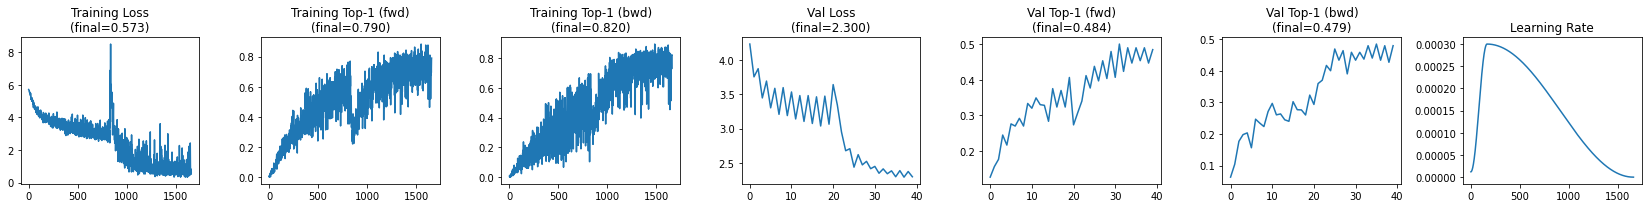

BrainNetwork(
  (lin0): Sequential(
    (0): Linear(in_features=15724, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [8]:
# Loading checkpoint  
ckpt_path = f'checkpoints/{model_name}_subj01_epoch19.pth'
print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)

print(f"Plotting results from {ckpt_path}")
train_losses=checkpoint['train_losses']
train_fwd_topk=checkpoint['train_fwd_topk']
train_bwd_topk=checkpoint['train_bwd_topk']
val_losses=checkpoint['val_losses']
val_fwd_topk=checkpoint['val_fwd_topk']
val_bwd_topk=checkpoint['val_bwd_topk']
lrs=checkpoint['lrs']

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(23,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]:.3f})")
ax1.plot(train_losses)
ax2.set_title(f"Training Top-1 (fwd)\n(final={train_fwd_topk[-1]:.3f})")
ax2.plot(train_fwd_topk)
ax3.set_title(f"Training Top-1 (bwd)\n(final={train_bwd_topk[-1]:.3f})")
ax3.plot(train_bwd_topk)
ax4.set_title(f"Val Loss\n(final={val_losses[-1]:.3f})")
ax4.plot(val_losses)
ax5.set_title(f"Val Top-1 (fwd)\n(final={val_fwd_topk[-1]:.3f})")
ax5.plot(val_fwd_topk)
ax6.set_title(f"Val Top-1 (bwd)\n(final={val_bwd_topk[-1]:.3f})")
ax6.plot(val_bwd_topk)
ax7.set_title(f"Learning Rate")
ax7.plot(lrs)
fig.tight_layout()
plt.show()
    
brain_net.load_state_dict(checkpoint['model_state_dict'])
brain_net.eval()
brain_net.requires_grad_(False)

In [9]:
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior

prior_network = DiffusionPriorNetwork(
    dim = 768,
    depth = 6,
    dim_head = 64,
    heads = 8
).to(device)

diffusion_prior = DiffusionPrior(
    net = prior_network,
    #clip = clip_model,
    image_embed_dim = 768,
    condition_on_text_encodings = False,
    timesteps = 100,
    cond_drop_prob = 0.2
).to(device)

In [10]:
epoch = 14
num_epochs = 60
lr = 3e-4
losses = []
optimizer = torch.optim.AdamW(diffusion_prior.parameters(), lr=lr)

# resume from checkpoint:
prior_checkpoint = torch.load(f'{ckpt_path[:-12]}_epoch{epoch}_diffusionprior.pth', 
                              map_location=device)
epoch = prior_checkpoint['epoch']+1
diffusion_prior.load_state_dict(prior_checkpoint['model_state_dict'])
losses = prior_checkpoint['train_losses']
optimizer.load_state_dict(prior_checkpoint['optimizer_state_dict'])
optimizer.param_groups[0]['lr'] = lr

In [13]:
# feed text and images into diffusion prior network
progress_bar = tqdm(range(epoch,num_epochs),ncols=250)
for epoch in progress_bar:
    diffusion_prior.train()
    for train_i, (voxel, image) in enumerate(train_dl):
        optimizer.zero_grad()
        image = image.to(device)

        clip_embed = brain_net(voxel.to(device).float())
        #clip_embed = nn.functional.normalize(clip_embed,dim=-1)

        # clip_embed = clip_extractor.embed_curated_annotations(subj01_annots[voxel])

        image_clip = clip_extractor.embed_image(image).float()

        loss = diffusion_prior(text_embed=clip_embed, image_embed=image_clip)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    diffusion_prior.eval()
    for val_i, (val_voxel, val_image) in enumerate(val_dl):
        with torch.no_grad(): 
            val_image = val_image.to(device)

            clip_embed = brain_net(val_voxel.to(device).float())
            #clip_embed = nn.functional.normalize(clip_embed,dim=-1)

            # clip_embed = clip_extractor.embed_curated_annotations(subj01_annots[voxel])

            image_clip = clip_extractor.embed_image(val_image).float()

            val_loss = diffusion_prior(text_embed=clip_embed, image_embed=image_clip)

            val_losses.append(val_loss.item())
    
    # Save model checkpoint every 5 epochs if full_training==True
    if (epoch+1)%5==0 and full_training:
        print(f'saving {ckpt_path[:-12]}_epoch{epoch}_diffusionprior.pth')
        if (using_ddp==False) or (using_ddp==True and local_rank==0):
            state_dict = brain_net.state_dict()
            if using_ddp: # if using DDP, convert DDP state_dict to non-DDP before saving
                for key in list(state_dict.keys()):
                    if 'module.' in key:
                        state_dict[key.replace('module.', '')] = state_dict[key]
                        del state_dict[key]   
            torch.save({
                'epoch': epoch,
                'model_state_dict': diffusion_prior.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': losses,
                'val_losses': val_losses,
                }, f'{ckpt_path[:-12]}_epoch{epoch}_diffusionprior.pth')
        if using_ddp:
            dist.barrier() # this tells the other gpus wait for the first gpu to finish saving the model
        
    logs = OrderedDict(
        loss=np.mean(losses[-(train_i+1):]),
        val_loss=np.mean(val_losses[-(val_i+1):]),
    )
    progress_bar.set_postfix(**logs)
    
plt.plot(losses)
plt.show()
plt.plot(val_losses)
plt.show()

  9%|████████████████▍                                                                                                                                                                        | 4/45 [13:04<2:13:09, 194.87s/it, loss=44.9, val_loss=55.9]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch19_diffusionprior.pth


 20%|█████████████████████████████████████                                                                                                                                                    | 9/45 [29:02<1:55:18, 192.17s/it, loss=38.9, val_loss=53.8]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch24_diffusionprior.pth


 31%|█████████████████████████████████████████████████████████▏                                                                                                                              | 14/45 [45:05<1:39:30, 192.58s/it, loss=34.4, val_loss=56.2]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch29_diffusionprior.pth


 42%|████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 19/45 [1:00:59<1:22:27, 190.30s/it, loss=31.3, val_loss=56.3]

saving checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch34_diffusionprior.pth


 51%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 23/45 [1:14:56<1:11:40, 195.48s/it, loss=27.9, val_loss=60.9]

KeyboardInterrupt



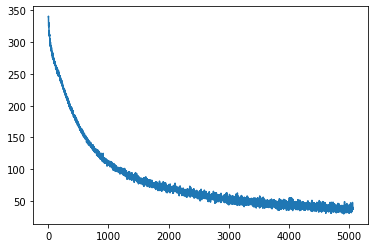

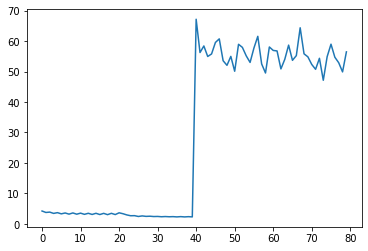

In [11]:
# load pretrained checkpoint
prior_ckpt_path = f'{ckpt_path[:-12]}_epoch24_diffusionprior.pth'
prior_checkpoint = torch.load(prior_ckpt_path, map_location=device)
losses = prior_checkpoint['train_losses']
val_losses = prior_checkpoint['val_losses']
diffusion_prior.load_state_dict(prior_checkpoint['model_state_dict'])
diffusion_prior=diffusion_prior.to(device)

diffusion_prior.eval()
diffusion_prior.requires_grad_(False)
prior_network.eval()
prior_network.requires_grad_(False)
brain_net.eval()
brain_net.requires_grad_(False)

plt.plot(losses)
plt.show()
plt.plot(val_losses)
plt.show()

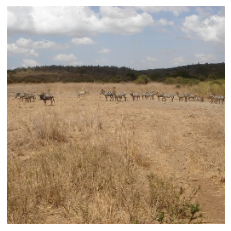

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

Cosine sim for CLIP-voxel x CLIP-image tensor([0.1516], device='cuda:0')
Cosine sim for CLIP-voxel-aligned x CLIP-image tensor([0.6884], device='cuda:0')


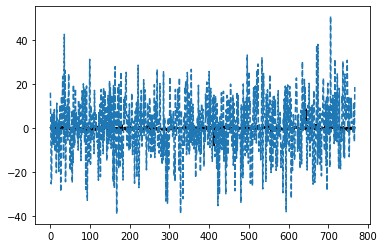

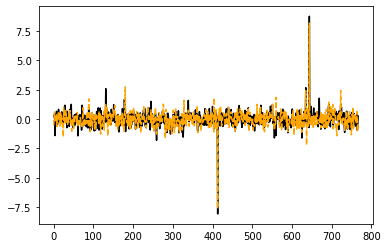

In [12]:
for i, (voxel, image) in enumerate(val_dl):
    image_test = image.to(device)
    clip_embed = brain_net(voxel.to(device).float())
    break

for idx in [22]:
    plt.imshow(torch_to_Image(image_test[idx]))
    plt.axis('off')
    plt.show()

    image_clip = clip_extractor.embed_image(image_test[idx][None])
    orig_vox_clip = clip_embed[idx][None]

    with torch.no_grad():
        align_vox_clip = diffusion_prior.p_sample_loop(clip_embed[idx][None].shape, 
                                                       text_cond = dict(text_embed = clip_embed[idx][None].long()), 
                                                       cond_scale = 1., timesteps = 100)
    
    print("Cosine sim for CLIP-voxel x CLIP-image", nn.functional.cosine_similarity(orig_vox_clip.float(),image_clip,dim=1))
    print("Cosine sim for CLIP-voxel-aligned x CLIP-image",nn.functional.cosine_similarity(align_vox_clip.float(),image_clip,dim=1))

    plt.plot(image_clip.detach().cpu().numpy().flatten(),c='k')
    plt.plot(orig_vox_clip.detach().cpu().numpy().flatten(),ls='--')
    plt.show()

    plt.plot(image_clip.detach().cpu().numpy().flatten(),c='k')
    plt.plot(align_vox_clip.detach().cpu().numpy().flatten(),c='orange',ls='--')
    plt.show()

# Test out feeding these aligned CLIP-voxel embeddings through Stable Diffusion (Image Variation) model

In [13]:
from diffusers import StableDiffusionImageVariationPipeline
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel
from transformers import CLIPVisionModelWithProjection, CLIPFeatureExtractor

cache_dir = '/scratch/gpfs/ps6938/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(cache_dir): # download from huggingface if not already downloaded / cached
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", revision="v2.0").to(device)
    cache_dir = "lambdalabs/sd-image-variations-diffusers"
    
unet = UNet2DConditionModel.from_pretrained(cache_dir,subfolder="unet").to(device)
vae = AutoencoderKL.from_pretrained(cache_dir,subfolder="vae").to(device)
noise_scheduler = PNDMScheduler.from_pretrained(cache_dir, subfolder="scheduler")

unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae.eval() # dont want to train model
vae.requires_grad_(False) # dont need to calculate gradients

def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image[0]

print("loaded pre-trained SD model!")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


loaded pre-trained SD model!


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

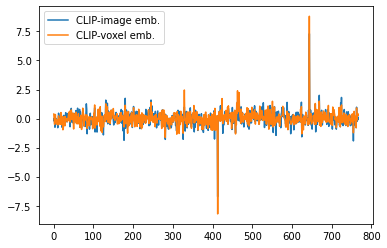

Cosine sim: tensor([0.8244], device='cuda:0')


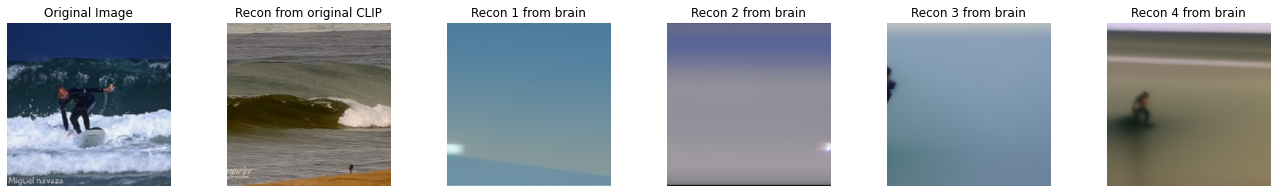

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

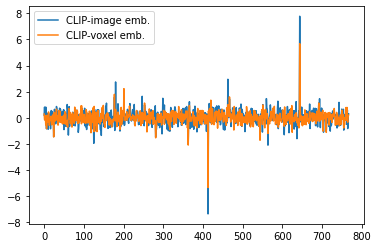

Cosine sim: tensor([0.5545], device='cuda:0')


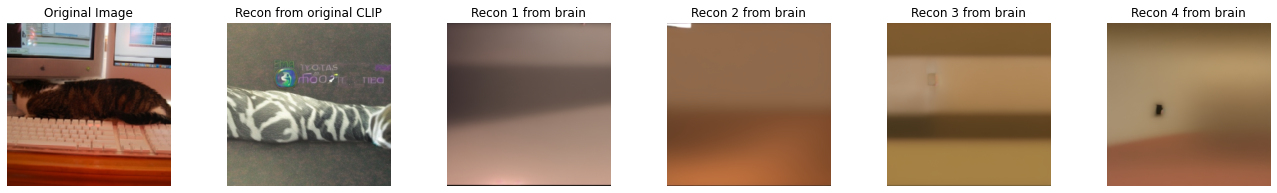

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

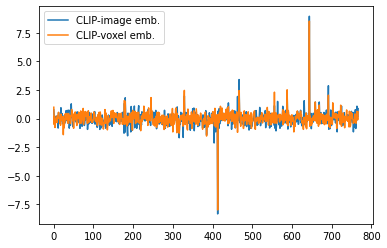

Cosine sim: tensor([0.7295], device='cuda:0')


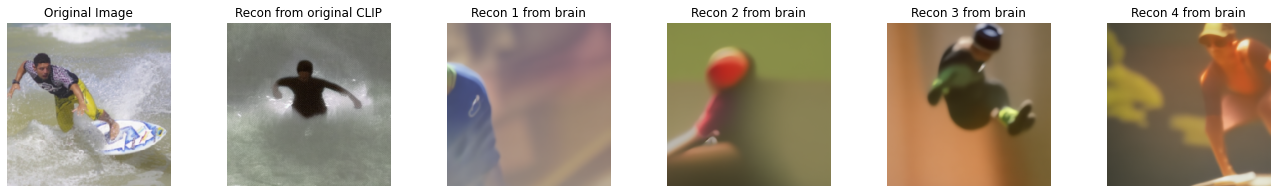

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

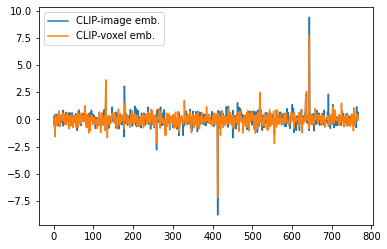

Cosine sim: tensor([0.6592], device='cuda:0')


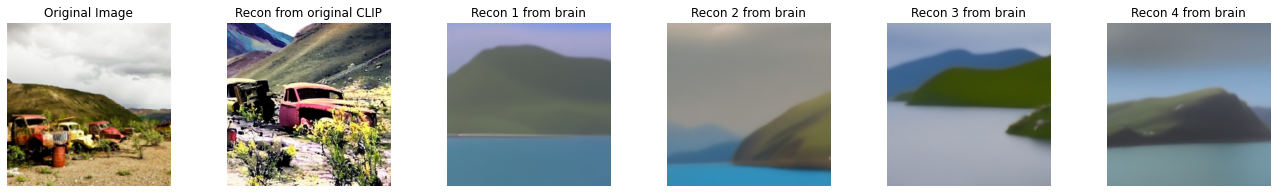

In [14]:
num_inference_steps = 20
clip_guidance_scale = 3 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
vox_guidance_scale = 3
num_per_sample = 4

for idx in range(4):
    image = clip_extractor.resize_image(image_test[[idx]])
    
    # Original clip embedding:
    clip_emb = clip_extractor.embed_image(image)
    clip_emb = torch.cat([torch.zeros_like(clip_emb), clip_emb]).unsqueeze(1).to(device).float()
    clip_latents = torch.randn([1, 4, 64, 64], device=device)

    # Encode voxels to CLIP space
    image_embeddings = brain_net(voxel[[idx]].to(device).float())
    # image_embeddings = nn.functional.normalize(image_embeddings,dim=-1) 
    # image_embeddings *= clip_emb[1].norm()/image_embeddings.norm() # note: this is cheating to equate norm scaling
    image_embeddings = diffusion_prior.p_sample_loop(image_embeddings.shape, 
                                           text_cond = dict(text_embed = image_embeddings), 
                                           cond_scale = 1., timesteps = num_inference_steps)
    plt.plot(clip_emb[1].detach().cpu().numpy().flatten(),label='CLIP-image emb.')
    plt.plot(image_embeddings.detach().cpu().numpy().flatten(),label='CLIP-voxel emb.')
    plt.legend()
    plt.show()
    print("Cosine sim:", nn.functional.cosine_similarity(image_embeddings,clip_emb[1],dim=1))
    
    # duplicate the embedding to serve classifier free guidance
    image_embeddings = image_embeddings.repeat(num_per_sample, 1)
    image_embeddings = torch.cat([torch.zeros_like(image_embeddings), image_embeddings]).unsqueeze(1).to(device)

    # Prepare timesteps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = noise_scheduler.timesteps
    latents = torch.randn([num_per_sample, 4, 64, 64], device=device)
    
    # Denoising loop (original clip)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([clip_latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=clip_emb).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + clip_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        clip_latents = noise_scheduler.step(noise_pred, t, clip_latents).prev_sample
        decoded_clip_image = decode_latents(clip_latents)
    
    # Denoising loop (brain recon)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + vox_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
    fig, ax = plt.subplots(1, 2+num_per_sample, figsize=(23,3))
    ax[0].set_title(f"Original Image")
    ax[0].imshow(torch_to_Image(image))
    ax[1].set_title(f"Recon from original CLIP")
    ax[1].imshow(torch_to_Image(decoded_clip_image))
    for i in range(2,2+num_per_sample):
        recon = decode_latents(latents[i-2].unsqueeze(0))
        ax[i].set_title(f"Recon {i-1} from brain")
        ax[i].imshow(torch_to_Image(recon))
    for i in range(2+num_per_sample):
        ax[i].axis('off')
    plt.show()          